In [10]:
from typing import Dict, Tuple

import numpy as np
import pandas as pd
from postprocess.lps_plots import sel_evaluation_domain
from products.plot_settings import MF_SYNOPSIS_VAR_NAME, NASA_L3_JPSS1_VAR_NAME,NASA_L3_MODIS_TERRA_VAR_NAME, NASA_L3_SNPP_VAR_NAME,MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME
from reductions.statistics_base import EvaluationVsHighResBase
from winter_year import WinterYear
import xarray as xr
from xarray.groupers import BinGrouper

wy = WinterYear(2023, 2024)
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_6_modis/analyses/"
)
analysis_type = "confusion_table"

analyses_dict_confusion = {

    NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_s2_theia.nc", decode_cf=True
    ),
    NASA_L3_MODIS_TERRA_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_terra_vs_s2_theia.nc",
        decode_cf=True,
    ),
}

analysis_type = "uncertainty"

analyses_dict_uncertainty = {

    NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_s2_theia.nc", decode_cf=True
    ),
    NASA_L3_MODIS_TERRA_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_terra_vs_s2_theia.nc",
        decode_cf=True,
    ),
}


def sel_evaluation_domain(analyses_dict: Dict[str, xr.Dataset]) ->Dict[str, xr.Dataset]:

    selection_dict={}
    for k, v in analyses_dict.items():
        if 'sensor_zenith_bins' not in v.sizes:
            selection_dict .update({
                k: v.expand_dims({'sensor_zenith_bins': 5})
                })
        else:
            selection_dict.update({k:v})

    selection_dict = {
        k: v.sel(
            time=slice("2023-12", "2024-06"),
            altitude_bins=slice(900, None),
            ref_bins=slice(0, 101),
            slope_bins=slice(None, 60),
            sensor_zenith_bins=slice(None,80)
        )
        for k, v in selection_dict.items()
    }

    selection_dict = {
        k: v.assign_coords(
            {
                "aspect_bins": pd.CategoricalIndex(
                    data=EvaluationVsHighResBase.aspect_bins().labels,
                    categories=EvaluationVsHighResBase.aspect_bins().labels,
                    ordered=True,
                ),
                "forest_mask_bins": ["Open", "Forest"],
                "slope_bins": np.array(["[0-10]", "[11-30]", ">30"], dtype=str),
                "sensor_zenith_bins": np.array(["[0-15]", "[15-30]", "[30-45]", "[45-60]",">60"], dtype=str),
            }
        )
        for k, v in selection_dict.items()
    }

    selection_dict = {
        k: v.rename(
            {"aspect_bins": "Aspect", "forest_mask_bins": "Landcover", "slope_bins": "Slope [°]", "sensor_zenith_bins": "View Zenith Angle [°]"}
        )
        for k, v in selection_dict.items()
    }

    return selection_dict



metrics_dict_conf = sel_evaluation_domain(analyses_dict=analyses_dict_confusion)
metrics_dict_conf = {k:v.groupby(ref_bins=BinGrouper(bins=[-1,0,99,100], labels=["0", "[1-99]", "100"])).sum().rename({"ref_bins_bins": "Ref FSC [%]"}) for k,v in metrics_dict_conf.items()}
metrics_dict_unc = sel_evaluation_domain(analyses_dict=analyses_dict_uncertainty)
metrics_dict_unc = {k:v.sum(dim=( 'time')).assign_coords(ref_bins=["0", "[1-15]", "[16-30]", "[31-45]","[46-60]","[61-75]", "[76-90]","[91-99]", "100"]).rename({"ref_bins": "Ref FSC [%]"}) for k,v in metrics_dict_unc.items()}

In [12]:
from typing import List
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.lines import Line2D
from postprocess.error_distribution import histograms_to_biais_rmse, histograms_to_distribution, postprocess_uncertainty_analysis
from postprocess.lps_plots import HandlerPoint, HandlerSpan, compute_skill_scores_for_parameter, plot_custom_spans, plot_synthesis, smooth_data_np_convolve
from products.plot_settings import PRODUCT_PLOT_COLORS, PRODUCT_PLOT_NAMES
import matplotlib.patches as mpatches


def plot_custom_spans(metrics_dict_unc: Dict[str, xr.Dataset], analysis_var: str, ax: plt.Axes):
    percentile_min, percentile_max = 25,75
    x_positions = np.arange(len(list(metrics_dict_unc.values())[0].coords[analysis_var].values))
    x_positions = x_positions / len(x_positions)
    for product_name, metrics_dataset in metrics_dict_unc.items():
        color = PRODUCT_PLOT_COLORS[product_name]
        analysis_coords = metrics_dict_unc[product_name].coords[analysis_var].values
        box_width_data = 0.2 / len(x_positions)
        for idx, value in enumerate(analysis_coords):
            x_pos = x_positions[idx]
            product_analysis_var_dataset = metrics_dataset.sel({analysis_var: value}).drop_sel(biais_bins=0)
            reduced = product_analysis_var_dataset.groupby("biais_bins").sum(list(product_analysis_var_dataset.sizes.keys()))
            smooth = smooth_data_np_convolve(reduced.data_vars["n_occurrences"], 1)
            smooth = smooth / smooth.max()

            biais_rmse = histograms_to_biais_rmse(reduced)
            distr = histograms_to_distribution(reduced)
            ax.scatter(x_pos, biais_rmse.data_vars["biais"], marker="o", color=color, s=15, zorder=3)

            whiskers_min = np.percentile(distr, percentile_min)
            whiskers_max = np.percentile(distr, percentile_max)
            ax.vlines(x_pos, whiskers_min, whiskers_max, color=color, linestyle="-", lw=3, label=product_name)

            ax.hlines(whiskers_min, x_pos - box_width_data / 2, x_pos + box_width_data / 2, color=color, lw=3)
            ax.hlines(whiskers_max, x_pos - box_width_data / 2, x_pos + box_width_data / 2, color=color, lw=3)
        x_positions = x_positions + box_width_data

    ax.set_xticks(x_positions - box_width_data * ((len(metrics_dict_unc) + 1) // 2), labels=analysis_coords)
    ax.set_xlim(x_positions[0] - (len(metrics_dict_unc) + 1) * box_width_data, x_positions[-1])
    ax.set_ylim(-40,40)
    ax.set_ylabel(f"MAE [% FSC]")
    ax.set_xlabel(analysis_var)
    (l1,) = ax.plot([0, 1], [0, 1], c="gray", lw=1e-12)
    (l2,) = ax.plot(0, 0, c="gray", markersize=1e-12)
    ax.legend(
        [l1, l2], [f"Q1 and Q3"], handler_map={l1: HandlerSpan(), l2: HandlerPoint()}
    )
    ax.grid(axis='y')

def plot_accuracy_f1_score(metrics_dict_conf: Dict[str, xr.Dataset], analysis_var: str, ax: Axes):
    skill_scores = compute_skill_scores_for_parameter(metrics_dict_conf, variable=analysis_var)
    skill_scores = skill_scores.where(skill_scores != 0, np.nan)
    x_coords_conf = metrics_dict_conf[list(metrics_dict_conf.keys())[0]].coords[analysis_var].values
    skill_scores = skill_scores.sel({analysis_var: x_coords_conf})
    for prod in metrics_dict_conf:
        ax.plot(
        x_coords_conf,
        skill_scores.sel(product=PRODUCT_PLOT_NAMES[prod]).data_vars["accuracy"],
        "-o",
        color=PRODUCT_PLOT_COLORS[prod],
        markersize=3,
        lw=2
    )
        ax.plot(
            x_coords_conf,
            skill_scores.sel(product=PRODUCT_PLOT_NAMES[prod]).data_vars["f1_score"],
            "--^",
            color=PRODUCT_PLOT_COLORS[prod],
            markersize=5,
            lw=3
        )
    ax.legend(
        [Line2D([0], [0], linestyle="-", color="gray"), Line2D([0], [0], linestyle="--", color="gray")],
        ["Accuracy", "F1 score"]
    )
    ax.set_ylim(0.75, 1)
    ax.set_ylabel("Score[-]")
    ax.set_xlabel(analysis_var)
    ax.grid(True)

def plot_rmse(metrics_dict_unc: Dict[str, xr.Dataset], analysis_var: str, ax: Axes):
    biais_rmse = postprocess_uncertainty_analysis(metrics_dict_unc, analysis_var=analysis_var)
    x_coords_unc = metrics_dict_unc[list(metrics_dict_unc.keys())[0]].coords[analysis_var].values
    biais_rmse = biais_rmse.sel({analysis_var: x_coords_unc})
    for prod in metrics_dict_unc:
        ax.plot( x_coords_unc,
                biais_rmse.data_vars["unbiaised_rmse"].sel(product=prod),
                "-o",
                color=PRODUCT_PLOT_COLORS[prod],
                markersize=5,
                lw=3
            )
    
    ax.grid(True)
    ax.set_ylim(5, 30)
    ax.set_ylabel("RMSE [% FSC]")
    ax.set_xlabel(analysis_var)
    ax.legend([Line2D([0], [0], linestyle="-", color="gray")], ["RMSE"])

def plot_product_legend(metrics_dict: Dict[str, xr.Dataset],legend_ax: Axes):
    custom_leg = [
            mpatches.Patch(color=PRODUCT_PLOT_COLORS[product_name], label=PRODUCT_PLOT_NAMES[product_name])
            for product_name in metrics_dict
        ]
        
    product_legend =legend_ax.legend(handles=custom_leg, loc='best')
    legend_ax.add_artist(product_legend)

def plot_one_var_analysis(metrics_dict_conf: Dict[str, xr.Dataset], metrics_dict_unc: Dict[str, xr.Dataset], analysis_var:str, axs: List[Axes]):
    if analysis_var=="View Zenith Angle [°]":
        plot_accuracy_f1_score(metrics_dict_conf={MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME:metrics_dict_conf[MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME]}, analysis_var=analysis_var,ax=axs[0])
        plot_custom_spans(metrics_dict_unc={MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME:metrics_dict_unc[MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME]}, analysis_var=analysis_var, ax=axs[2])
        plot_rmse(metrics_dict_unc={MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME:metrics_dict_unc[MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME]}, analysis_var=analysis_var,ax=axs[1])
    else:
        plot_accuracy_f1_score(metrics_dict_conf, analysis_var=analysis_var,ax=axs[0])
        plot_rmse(metrics_dict_unc, analysis_var=analysis_var,ax=axs[1])
        plot_custom_spans(metrics_dict_unc=metrics_dict_unc, analysis_var=analysis_var, ax=axs[2])
def plot_grid(metrics_dict_conf: Dict[str, xr.Dataset], metrics_dict_unc: Dict[str, xr.Dataset], params_list:List[str], axs: List[Axes]):
    for i, var in enumerate(params_list):
        if var=="View Zenith Angle [°]":
            plot_one_var_analysis(metrics_dict_conf={MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME:metrics_dict_conf[MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME]},
                                  metrics_dict_unc={MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME:metrics_dict_unc[MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME]},
                                  analysis_var=var,
                                  axs=axs[i])
        else:
            plot_one_var_analysis(metrics_dict_conf, metrics_dict_unc, var,axs[i])



# params = ["Ref FSC [%]", "View Zenith Angle [°]"] 
# fig, axs = plt.subplots(len(params), 3, figsize=(14,3  * len(params)), layout="constrained")
# plt.style.use('default')
# plt.rcParams["font.family"] = "Noto Sans"
# plot_synthesis(metrics_dict_conf, metrics_dict_unc, params_list=params, axs=axs)
# fig.patch.set_alpha(0.0)
# fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/lps/poster/illustrations/evaluation_multiplot_ref_fsc_vza.png', format='png')

/home/imperatoren/miniconda3/envs/viirs_env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Noto Sans.
  func(*args, **kwargs)
/home/imperatoren/miniconda3/envs/viirs_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Noto Sans.
  fig.canvas.print_figure(bytes_io, **kw)


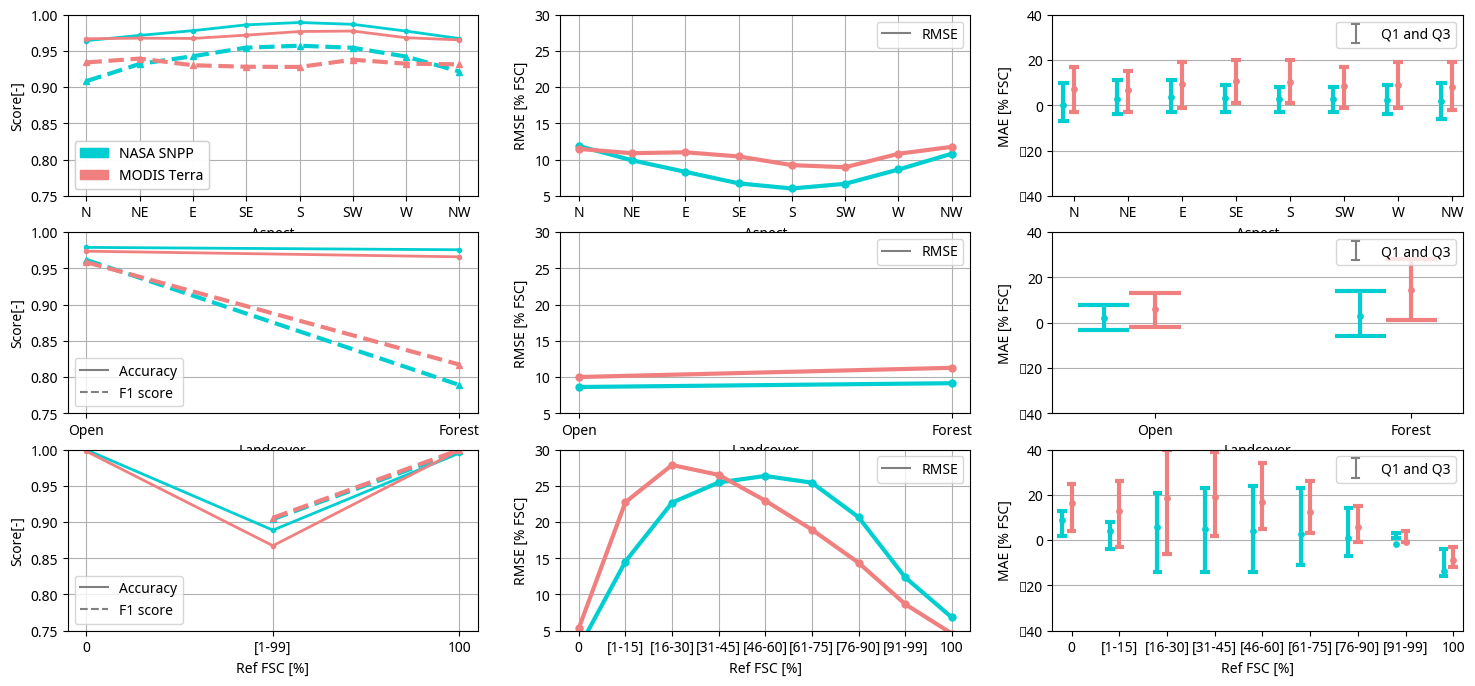

In [14]:
params = ['Aspect', 'Landcover', 'Ref FSC [%]']
fig, axs = plt.subplots(len(params),3,figsize=(18,8 ))
plt.rcParams["font.family"] = "Noto Sans"
plot_grid(metrics_dict_conf=metrics_dict_conf,metrics_dict_unc=metrics_dict_unc, params_list=params,axs=axs)
plot_product_legend(metrics_dict=metrics_dict_conf,legend_ax=axs[0,0])
fig.patch.set_alpha(0.0)


In [16]:
from typing import Dict

import numpy as np

from products.plot_settings import NASA_L3_MULTIPLATFORM_VAR_NAME, PRODUCT_PLOT_COLORS, NASA_L3_JPSS1_VAR_NAME, NASA_L3_SNPP_VAR_NAME, MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME
import xarray as xr
from matplotlib import pyplot as plt
from postprocess.error_distribution import histograms_to_biais_rmse

analysis_type = "completeness"
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_6_modis/analyses/"
)
analyses_dict_completeness = {
    # MF_NO_FOREST_RED_BAND_SCREEEN_VAR_NAME: xr.open_dataset(
    #     f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_meteofrance_no_forest_red_band_screen.nc",
    #     decode_cf=True,
    # ),

    NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp.nc", decode_cf=True
    ),
    NASA_L3_MODIS_TERRA_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_terra.nc",
        decode_cf=True,
    ),

}

metrics_dict_completeness = {k:v.sel(time=slice('2023-11', '2024-06')) for k,v in analyses_dict_completeness.items()}

analysis_type = "uncertainty"

analyses_dict_uncertainty = {
    NASA_L3_MODIS_TERRA_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_terra_vs_s2_theia.nc", decode_cf=True
    ),
    NASA_L3_SNPP_VAR_NAME: xr.open_dataset(
        f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_snpp_vs_s2_theia.nc", decode_cf=True
    ),
}

metrics_dict_unc = {k:v.resample({"time": "1ME"}).sum(dim="time") for k,v in analyses_dict_uncertainty.items()}
metrics_dict_unc = {k:v.groupby("time").map(histograms_to_biais_rmse) for k,v in metrics_dict_unc.items()}

<Figure size 640x480 with 0 Axes>

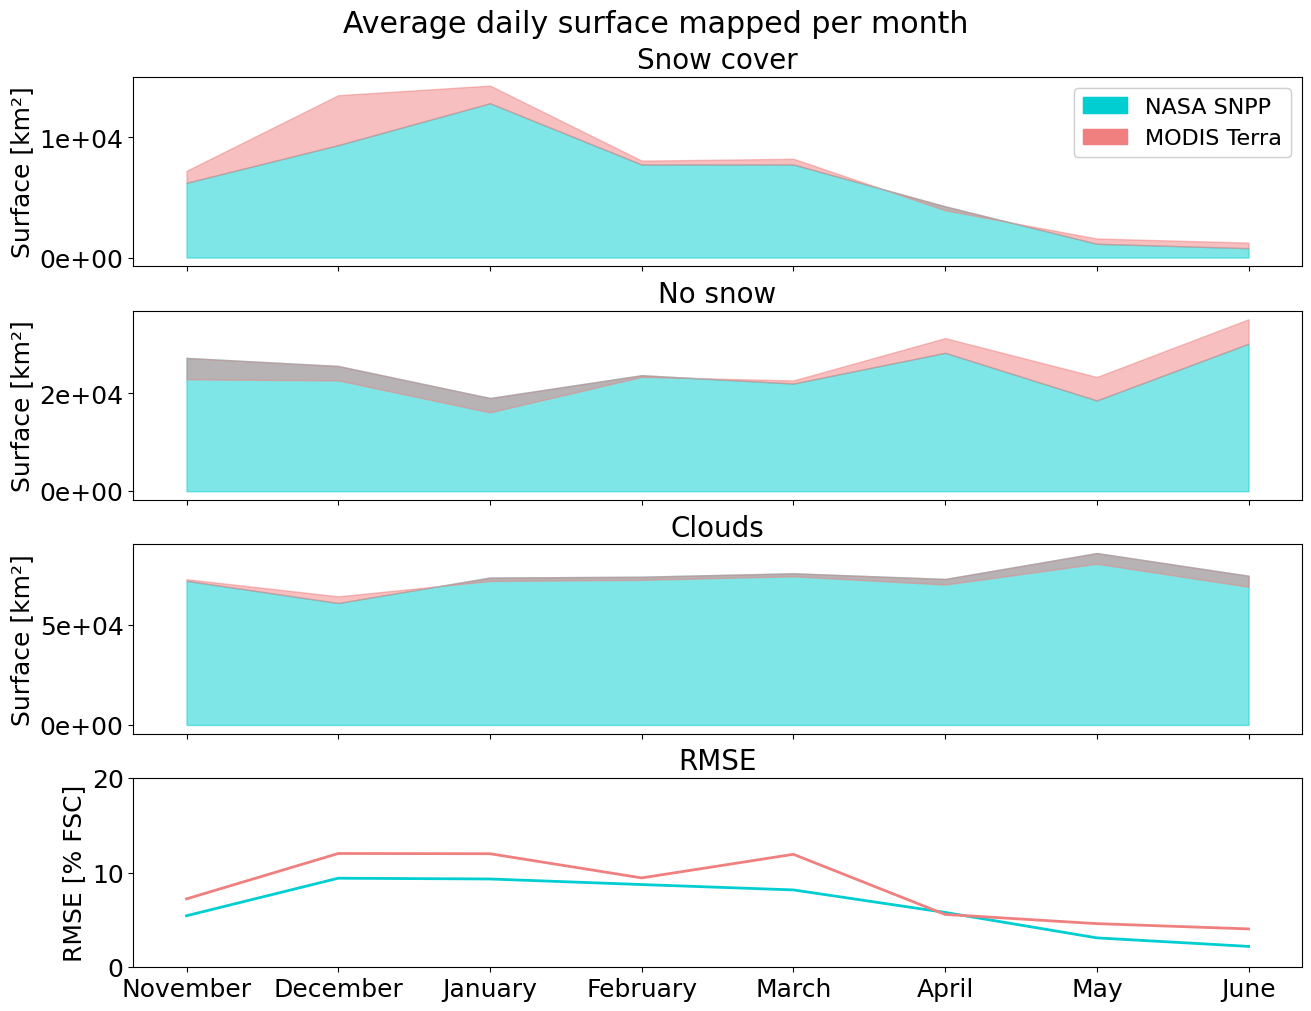

In [18]:
from matplotlib import font_manager, ticker
from postprocess.lps_plots import annual_area_fancy_plot
from typing import Any, Dict, List, Tuple
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import xarray as xr
from products.plot_settings import PRODUCT_PLOT_COLORS, PRODUCT_PLOT_NAMES
from products.plot_settings import (
    NASA_L3_JPSS1_VAR_NAME,
    NASA_L3_MULTIPLATFORM_VAR_NAME,
    NASA_L3_SNPP_VAR_NAME)

def annual_area_fancy_plot(metrics_dict_completeness: Dict[str, xr.Dataset], metrics_dict_uncertainty: Dict[str, xr.Dataset],axs: List[Axes]| None = None):
    if len(metrics_dict_completeness) > 1:
        common_days = np.intersect1d(*[v.coords["time"] for v in metrics_dict_completeness.values()][:2])

    if len(metrics_dict_completeness) > 2:
        for v in metrics_dict_completeness.values():
            common_days = np.intersect1d(common_days, v.coords["time"])
    if axs is None: 
        _, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True, layout="constrained")

    [ax.set_ylabel("Surface [km²]", fontsize=18) for ax in axs[:3]]
    axs[3].set_ylabel("RMSE [% FSC]", fontsize=18)
    custom_leg = [
        mpatches.Patch(color=PRODUCT_PLOT_COLORS[product_name], label=PRODUCT_PLOT_NAMES[product_name])
        for product_name in metrics_dict_completeness
    ]
    product_legend = axs[0].legend(handles=custom_leg, fontsize=16)
    axs[0].add_artist(product_legend)
    old_snow_cover, old_no_snow, old_clouds = 0, 0, 0
    for product in metrics_dict_completeness:
        metrics_dict_completeness[product] = metrics_dict_completeness[product].sel(time=common_days)
        product_monthly_averages = (
            metrics_dict_completeness[product].resample({"time": "1ME"}).mean(dim="time").data_vars["surface"] * 1e-6
        )

        snow_cover = product_monthly_averages.sel(class_name="snow_cover")
        axs[0].fill_between(
            np.arange(product_monthly_averages.sizes["time"]),
            snow_cover,
            old_snow_cover,
            alpha=0.5,
            color=PRODUCT_PLOT_COLORS[product],
        )
        old_snow_cover = snow_cover
        no_snow = product_monthly_averages.sel(class_name="no_snow")
        axs[1].fill_between(
            np.arange(product_monthly_averages.sizes["time"]),
            no_snow,
            old_no_snow,
            alpha=0.5,
            color=PRODUCT_PLOT_COLORS[product],
        )
        old_no_snow = no_snow

        axs[3].plot(
            np.arange(product_monthly_averages.sizes["time"]),
            metrics_dict_uncertainty[product].rmse,
            color=PRODUCT_PLOT_COLORS[product],
            lw=2,
        )
    axs[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0e}"))
    axs[1].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0e}"))
    axs[2].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0e}"))
    axs[3].set_ylim(0, 20)
    for product in [ NASA_L3_SNPP_VAR_NAME,NASA_L3_MODIS_TERRA_VAR_NAME]:
        product_monthly_averages = (
            metrics_dict_completeness[product].resample({"time": "1ME"}).mean(dim="time").data_vars["surface"] * 1e-6
        )
        clouds = product_monthly_averages.sel(class_name="clouds")
        axs[2].fill_between(
            np.arange(product_monthly_averages.sizes["time"]),
            clouds,
            old_clouds,
            alpha=0.5,
            color=PRODUCT_PLOT_COLORS[product],
        )
        old_clouds = clouds
    axs[2].set_xticks(np.arange(product_monthly_averages.sizes["time"]))
    axs[2].set_xticklabels(product_monthly_averages.coords["time"].to_dataframe().index.strftime("%B"),fontsize=18)
    axs[0].set_title("Snow cover",fontsize=20)
    axs[1].set_title("No snow",fontsize=20)
    axs[2].set_title("Clouds",fontsize=20)
    axs[3].set_title("RMSE",fontsize=20)

plt.rcParams["font.family"] = "Noto Sans"
font = {'family' : 'Sans Serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
plt.subplots_adjust(bottom=0.18)
fig, axs = plt.subplots(4, 1, figsize=(13, 10), sharex=True, layout="constrained")
fig.suptitle("Average daily surface mapped per month")
annual_area_fancy_plot(metrics_dict_completeness=metrics_dict_completeness,metrics_dict_uncertainty=metrics_dict_unc, axs=axs)
fig.patch.set_alpha(0.0)
fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/lps/poster/illustrations/area_composite.png', format='png')

In [19]:

### NDSI-FSC regression
from matplotlib import cm, colors
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from fractional_snow_cover import gascoin, salomonson_appel
from postprocess.scatter_plot import fancy_scatter_plot, fit_regression
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
analysis_type = "scatter"
analysis_folder = (
    "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_6_modis/analyses/"
)
nasa_l3_modis_metrics_ds = xr.open_dataset(
    f"{analysis_folder}/{analysis_type}/{analysis_type}_WY_2023_2024_nasa_l3_modis_NDSI_vs_s2_theia_FSC.nc", decode_cf=True
)
nasa_l3_snpp_metrics_ds = nasa_l3_modis_metrics_ds.where(nasa_l3_modis_metrics_ds > 0, drop=True)

plt.rcParams["font.family"] = "Noto Sans"
font = {'family' : 'Sans Serif',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
plt.subplots_adjust(bottom=0.18)
fig, ax = plt.subplots(1,2, figsize=(15, 6), sharex=True, layout="constrained")
fig.suptitle("Scatter plot NASA VNP10 NDSI vs S2 FSC")

def fancy_scatter_plot(
    data_to_plt: xr.DataArray,
    ax: Axes,
    figure: Figure,
    low_threshold: int | None = None,
    smoothing_window_size: int | None = 2,
):
    data_to_plt = data_to_plt.transpose("y", "x")
    if low_threshold is not None:
        data_to_plt = data_to_plt.where(data_to_plt >= low_threshold, 0)
    if smoothing_window_size is not None:
        data_smooth = gaussian_filter(data_to_plt, sigma=smoothing_window_size)
    else:
        # That's ugly
        data_smooth = data_to_plt

    coeff_slope, intercept, score = fit_regression(data_to_plt)
    distr_min, distr_max = np.quantile(data_smooth, 0.20), np.quantile(data_smooth, 0.90)
    scatter_plot = ax.pcolormesh(
        data_to_plt.coords["x"].values,
        data_to_plt.coords["y"].values,
        data_smooth,
        norm=colors.LogNorm(vmin=distr_min if distr_min > 0 else 1, vmax=distr_max, clip=True),
        cmap=cm.bone,
    )
    regression_x_axis = np.arange(0, 100)
    ax.plot(
        regression_x_axis,
        regression_x_axis * coeff_slope + intercept,
        ":",
        lw=1.5,
        color="chocolate",
        label=f"Linear fit R²={score:.2f}",  # m={float(coeff_slope):.2f} b={float(intercept):.2f}",
    )
    # ax.plot(regression_x_axis, regression_x_axis, color="k", linewidth=0.5, label="y=x")
    ax.grid(False)
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5), draggable=True,fontsize=14)
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 100)

    cbar = figure.colorbar(scatter_plot, extend="max")
    cbar_ticks = np.array([1e1, 1e2])
    cbar_labels = [f"{tick:n}" for tick in cbar_ticks]
    cbar.set_ticks(cbar_ticks, labels=cbar_labels)
    return scatter_plot


# ax[0].set_facecolor('#222')
FOREST_TITLE = {'no_forest': 'Open', 'forest': 'Forest'}
for i, fore in enumerate(["no_forest", "forest"]):

    n_min = 0
    fig.suptitle("Scatter plot VIIRS NDSI_Snow_Cover vs S2 FSC")
    reduced = (
        nasa_l3_snpp_metrics_ds.sel(
            ref_bins=slice(0, 99),
            forest_mask_bins=[fore],
            test_bins=slice(0, 99),
        )
        .sum(dim=("forest_mask_bins", "time"))
        .data_vars["n_occurrences"]
    )
    xax = reduced.test_bins.values
    f_veg=0 if fore=="no_forest" else 0.5
    fit_g = gascoin(xax * 0.01, f_veg=f_veg) * 100
    ax[i].plot(xax, salomonson_appel(xax), color="chocolate", linewidth=1.5, label="(Salomonson and Appel, 2006)")
    ax[i].plot(xax, fit_g,"-.",color="chocolate", linewidth=1.5, label=f"(Gascoin et al., 2021)  fveg={int(f_veg*100)}%")

    scatter_plot = fancy_scatter_plot(
        data_to_plt=reduced.rename({"ref_bins": "y", "test_bins": "x"}),
        ax=ax[i],
        figure=fig,
        low_threshold=n_min,
        smoothing_window_size=0,
    )
    # ax[i].set_title(PRODUCT_PLOT_NAMES[k])
    ax[i].set_ylabel("S2 FSC [%]")
    ax[i].set_xlabel("NASA VIIRS SNPP NDSI [%]")
    ax[i].set_title(FOREST_TITLE[fore], fontsize=20)


plt.show()

fig.patch.set_alpha(0.0)
fig.savefig('/home/imperatoren/work/VIIRS_S2_comparison/lps/poster/illustrations/scatter.png', format='png',bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: '/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_6_modis/analyses/scatter/scatter_WY_2023_2024_nasa_l3_modis_NDSI_vs_s2_theia_FSC.nc'